In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "DejaVu Sans"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

import math
import os

from lmfit import Minimizer, Parameters, create_params, report_fit, Model

import sys
sys.path.append('..')

%cd ..
from RW_NN_ext import IQ_gen_NN, IQ_gen_NN_cpu

%cd -

/SNS/users/ccu/Documents/Randomwave_ML/generative_NN


2024-09-05 17:05:43.670175: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 17:05:43.785981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/opt/thinlinc/lib64:/opt/thinlinc/lib
2024-09-05 17:05:43.786009: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-09-05 17:05:43.80

tensorflow version = 2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14661521761930519230
xla_global_id: -1
]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_de (Dense)            (None, 3024)              12096     
                                                                 
 reshape_1 (Reshape)         (None, 63, 48)            0         
                                                                 
 conv1dtrs_de (Conv1DTranspo  (None, 126, 48)          11568     
 se)                                                             
                                                                 
 conv1d_transpose (Conv1DTra  (None, 126, 1)           241       
 nspose)                                                         
                                                                 
 reshape_2 (Reshape)     

2024-09-05 17:05:48.187567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 17:05:48.215661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/SNS/software/lib64:/SNS/software/lib:/usr/lib64/gstreamer-0.10:/opt/thinlinc/lib64:/opt/thinlinc/lib
2024-09-05 17:05:48.215812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open 

## load experimental data

In [2]:
def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    DI_ex = IQ_er
    DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    DI_ex_pos = DI_ex[2*n:]
    DI_ex_neg = DI_ex[:-2*n]
    DI_ex = DI_ex[n:-n]

    DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return Q_des, I_des, DI_des

In [3]:
# filename = "../../Data/Summary_NSE_EQSANS/L62_NoLi.txt"
# data_IQ = np.loadtxt(filename, delimiter='\t', skiprows=0, max_rows=300)
# Q = data_IQ[:,0]
# IQ = data_IQ[:,1]
# IQ_er = data_IQ[:,2]
# data_res = np.loadtxt(filename, delimiter='\t', skiprows=301, max_rows=300)[:,1]

filename = "../../Data/Summary_NSE_EQSANS/L62.csv"
data_IQ = np.loadtxt(filename, delimiter=',').T
Q = data_IQ[:,0]
IQ = data_IQ[:,1]
IQ_er = data_IQ[:,2]
sigma_Q = data_IQ[:,3]

Q_des, I_des, DI_des = desmear(Q,IQ,IQ_er,sigma_Q,n=3)

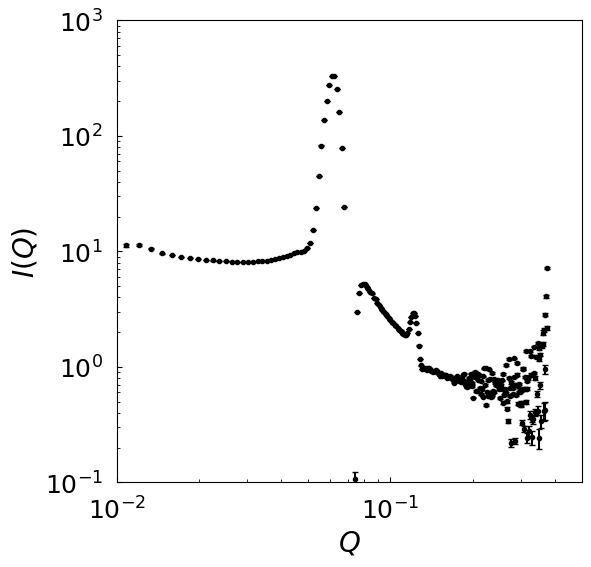

In [4]:
## plot loaded data
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']
ax.plot(Q_des,I_des,'.',color = 'k')
ax.errorbar(Q_des,I_des,DI_des,linestyle='', color = 'k' ,capsize=2)

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([0.01,0.5])
ax.set_ylim([0.1,1000])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
# ax.legend()

In [5]:
box_size = 2
n_grid_scale = 256
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

## peak_position
index_peak_range = Q_des>4e-2
Q_peak_range = Q_des[index_peak_range]
IQ_peak_range = I_des[index_peak_range]

index_Q_max = np.argmax(IQ_peak_range)
Q_max = Q_peak_range[index_Q_max]
print(Q_max)
Q_rs = Q_des/Q_max*np.pi*20

Q_d_err = Q_peak_range[(index_Q_max-5):(index_Q_max+5)]
IQ_d_err = IQ_peak_range[(index_Q_max-5):(index_Q_max+5)]
delta_Q = np.sqrt(np.sum(IQ_d_err*(Q_d_err-Q_max)**2)/np.sum(IQ_d_err))
print(delta_Q)

f_interp = interp.interp1d(Q_rs, I_des, kind='linear',fill_value='extrapolate')
IQ_interp = f_interp(qq)
IQ_interp[IQ_interp<0] = 1e-2

f_interp_er = interp.interp1d(Q_rs, DI_des, kind='linear',fill_value='extrapolate')
IQ_er_interp = f_interp_er(qq)
IQ_er_interp[IQ_er_interp<0] = 0

0.0611769
0.0027854827894422765


## Fit the data

In [6]:
# fitting targets
index_data = 0
IQ_data = IQ_interp[1:-1]
IQ_er_data = IQ_er_interp[1:-1]
qq_data = qq[1:-1]
index_Q = (qq_data/np.pi/20>0.7)*(qq_data/np.pi/20<6)

# create parameters for fitting
fp_names = ['sigma_k', 'kappa', 'alpha', 'y_scale', 'x_scale', 'bg']

params = Parameters()
params.add('sigma_k', value=0.1, min=0.01, max=1.0)
params.add('kappa', value=20, min=15, max=60)
params.add('alpha', value=0.2, min=0.0, max=1.0)
params.add('y_scale', value=6.3e6, min=1e5, max=1e7)
params.add('x_scale', value=1.01, min=0.9, max=1.1)
params.add('bg', value=0.8, min=0.1, max=2)

## define loss
def IQ_th(params, Q):
    v = params.valuesdict()
    fp = [v['sigma_k'],v['kappa'],v['alpha']]
    log_IQ_NN = np.log(IQ_gen_NN(fp))
    log_IQ_NN = gaussian_filter(log_IQ_NN,1)
    Q_scaled = Q*v['x_scale']
    f_interp = interp.interp1d(Q_scaled, log_IQ_NN, kind='cubic', fill_value='extrapolate')
    IQ_scaled = np.exp(f_interp(Q))
    return IQ_scaled*v['y_scale']+v['bg']

def lmbda(params, Q, IQ_exp, IQ_er_exp, index_Q=np.arange(len(Q))):
    IQ = IQ_th(params, Q)
    minimizer_target = lambda x, y, z: (np.log(x/y))/np.log(1+z/y)
    # minimizer_target = lambda x, y, z: (x-y)**2
    return minimizer_target(IQ[index_Q],IQ_exp[index_Q],IQ_er_exp[index_Q])


# do fit, here with the default leastsq algorithm
minner = Minimizer(lmbda, params, fcn_args=(qq_data, IQ_data, IQ_er_data, index_Q))
result = minner.minimize('nelder')
# result = minner.minimize('nelder')
# result = minner.brute(Ns=5)

# write error report
report_fit(result)
# result_list.append(result)
v_result = result.params.valuesdict()


[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1008
    # data points      = 106
    # variables        = 6
    chi-square         = 1432474.90
    reduced chi-square = 14324.7490
    Akaike info crit   = 1020.21636
    Bayesian info crit = 1036.19700
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    sigma_k:  0.01000000 (init = 0.1)
    kappa:    22.3328805 (init = 20)
    alpha:    0.14120824 (init = 0.2)
    y_scale:  8436120.33 (init = 6300000)
    x_scale:  1.01950228 (init = 1.01)
    bg:       0.37980163 (init = 0.8)


/tmp/ipykernel_2107638/112893874.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(qq_plot,IQ_plot*10**(index_data*2),


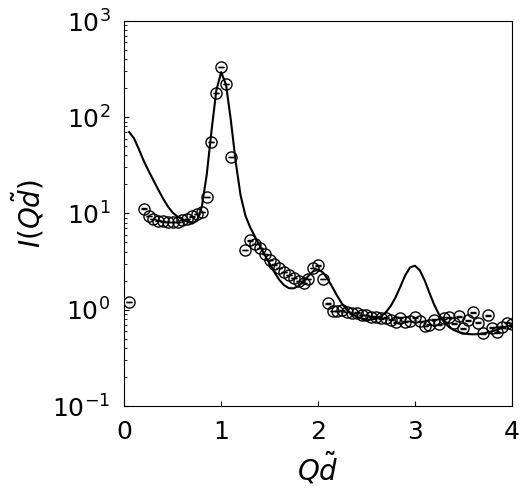

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

## plot fitting results
index_plot = np.arange(len(qq_data))
qq_plot = qq_data[index_plot]/np.pi/20
IQ_plot = IQ_data[index_plot]
IQ_er_plot = IQ_er_data[index_plot]
ax.plot(qq_plot,IQ_plot*10**(index_data*2),
        'or',fillstyle='none',ms=8, color = 'k')
ax.errorbar(qq_plot,IQ_plot*10**(index_data*2),IQ_er_plot*10**(index_data*2),
            linestyle='', color = 'k',capsize=2)
# ax.plot(qq_data[index_Q]/np.pi/20,IQ_th(params,qq_data)[index_Q],'k--')
ax.plot(qq_data[index_plot]/np.pi/20,
        IQ_th(result.params,qq_data)[index_plot]*10**(index_data*2),'k-')

ax.set_xlabel(r'$Q\tilde{d}$',fontsize=20)
ax.set_ylabel(r'$I(Q\tilde{d})$',fontsize=20)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim([0,4])
ax.set_ylim([0.1,1000])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)